## CAR PRICE PREDICTION

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,scale,KBinsDiscretizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import xgboost as xgb
import warnings
import optuna
import pickle
warnings.filterwarnings('ignore')

In [14]:
def evaluation_regression(pred,y_test):
    mse=mean_squared_error(pred,y_test)
    rmse=np.sqrt(mse)
    r_squared=r2_score(pred,y_test)
    mae=mean_absolute_error(pred,y_test)
    print(f"mse:{mse}")
    print(f"rmse:{rmse}")
    print(f"mae:{mae}")
    print(f"r_squared:{r_squared}")
    return [mse,rmse,mae,r_squared]

In [15]:
df=pd.read_csv('CarPrice_Assignment.csv')

In [64]:
df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

## convert column with string to interger

In [16]:
#convert doornumber column
to_replaces=df['doornumber'].unique()
values=[2,4]
df['doornumber'].replace(to_replace=to_replaces,value=values,inplace=True)
pd.to_numeric('doornumber',errors='coerce')

#convert cylindernumber
to_replaces=df['cylindernumber'].unique()
values=[4,6,5,3,12,2,8]
df['cylindernumber'].replace(to_replace=to_replaces,value=values,inplace=True)
pd.to_numeric('cylindernumber',errors='coerce')



nan

In [22]:
df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

In [34]:
df['stroke'].unique()

array([2.68 , 3.47 , 3.4  , 2.8  , 3.19 , 3.39 , 3.03 , 3.11 , 3.23 ,
       3.46 , 3.9  , 3.41 , 3.07 , 3.58 , 4.17 , 2.76 , 3.15 , 3.255,
       3.16 , 3.64 , 3.1  , 3.35 , 3.12 , 3.86 , 3.29 , 3.27 , 3.52 ,
       2.19 , 3.21 , 2.9  , 2.07 , 2.36 , 2.64 , 3.08 , 3.5  , 3.54 ,
       2.87 ])

In [5]:
df.describe()

,car_ID,symboling,doornumber,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,3.121951,98.756585,174.049268,65.907805,53.724878,2555.565854,4.380488,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,0.994966,6.021776,12.337289,2.145204,2.443522,520.680204,1.080854,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,2.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,2.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,4.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,4.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,4.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,4.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,4.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,4.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,12.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    int64  
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    int64  
 16  enginesize        205 non-null    int64  
 1

In [7]:
df['price'].dtype=='float64'

True

In [8]:
df.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

## EXPLANATORY DATA ANALYSIS

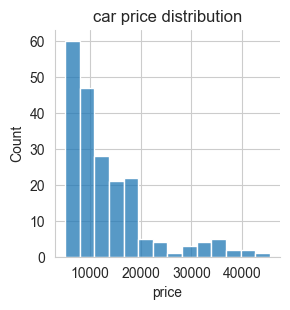

In [141]:
sns.set_style('whitegrid')
sns.displot(df,x='price',height=3).set(title='car price distribution')

(array([55., 51., 49., 13., 23.,  8.,  4.,  0.,  1.,  1.]),
 array([ 48.,  72.,  96., 120., 144., 168., 192., 216., 240., 264., 288.]),
 <BarContainer object of 10 artists>)

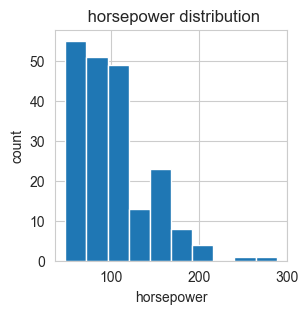

In [142]:
plt.figure(figsize=(3,3))
plt.title(' horsepower distribution')
plt.xlabel('horsepower')
plt.ylabel('count')
plt.hist(data=df,x='horsepower')

(array([12., 46., 24., 56., 18., 31., 15.,  0.,  1.,  2.]),
 array([13. , 16.6, 20.2, 23.8, 27.4, 31. , 34.6, 38.2, 41.8, 45.4, 49. ]),
 <BarContainer object of 10 artists>)

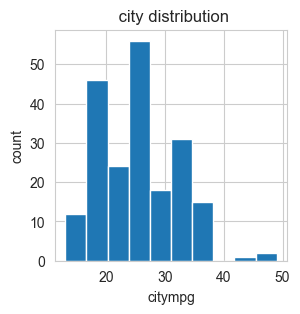

In [117]:
plt.figure(figsize=(3,3))
plt.title(' city distribution')
plt.xlabel('citympg')
plt.ylabel('count')
plt.hist(data=df,x='citympg')

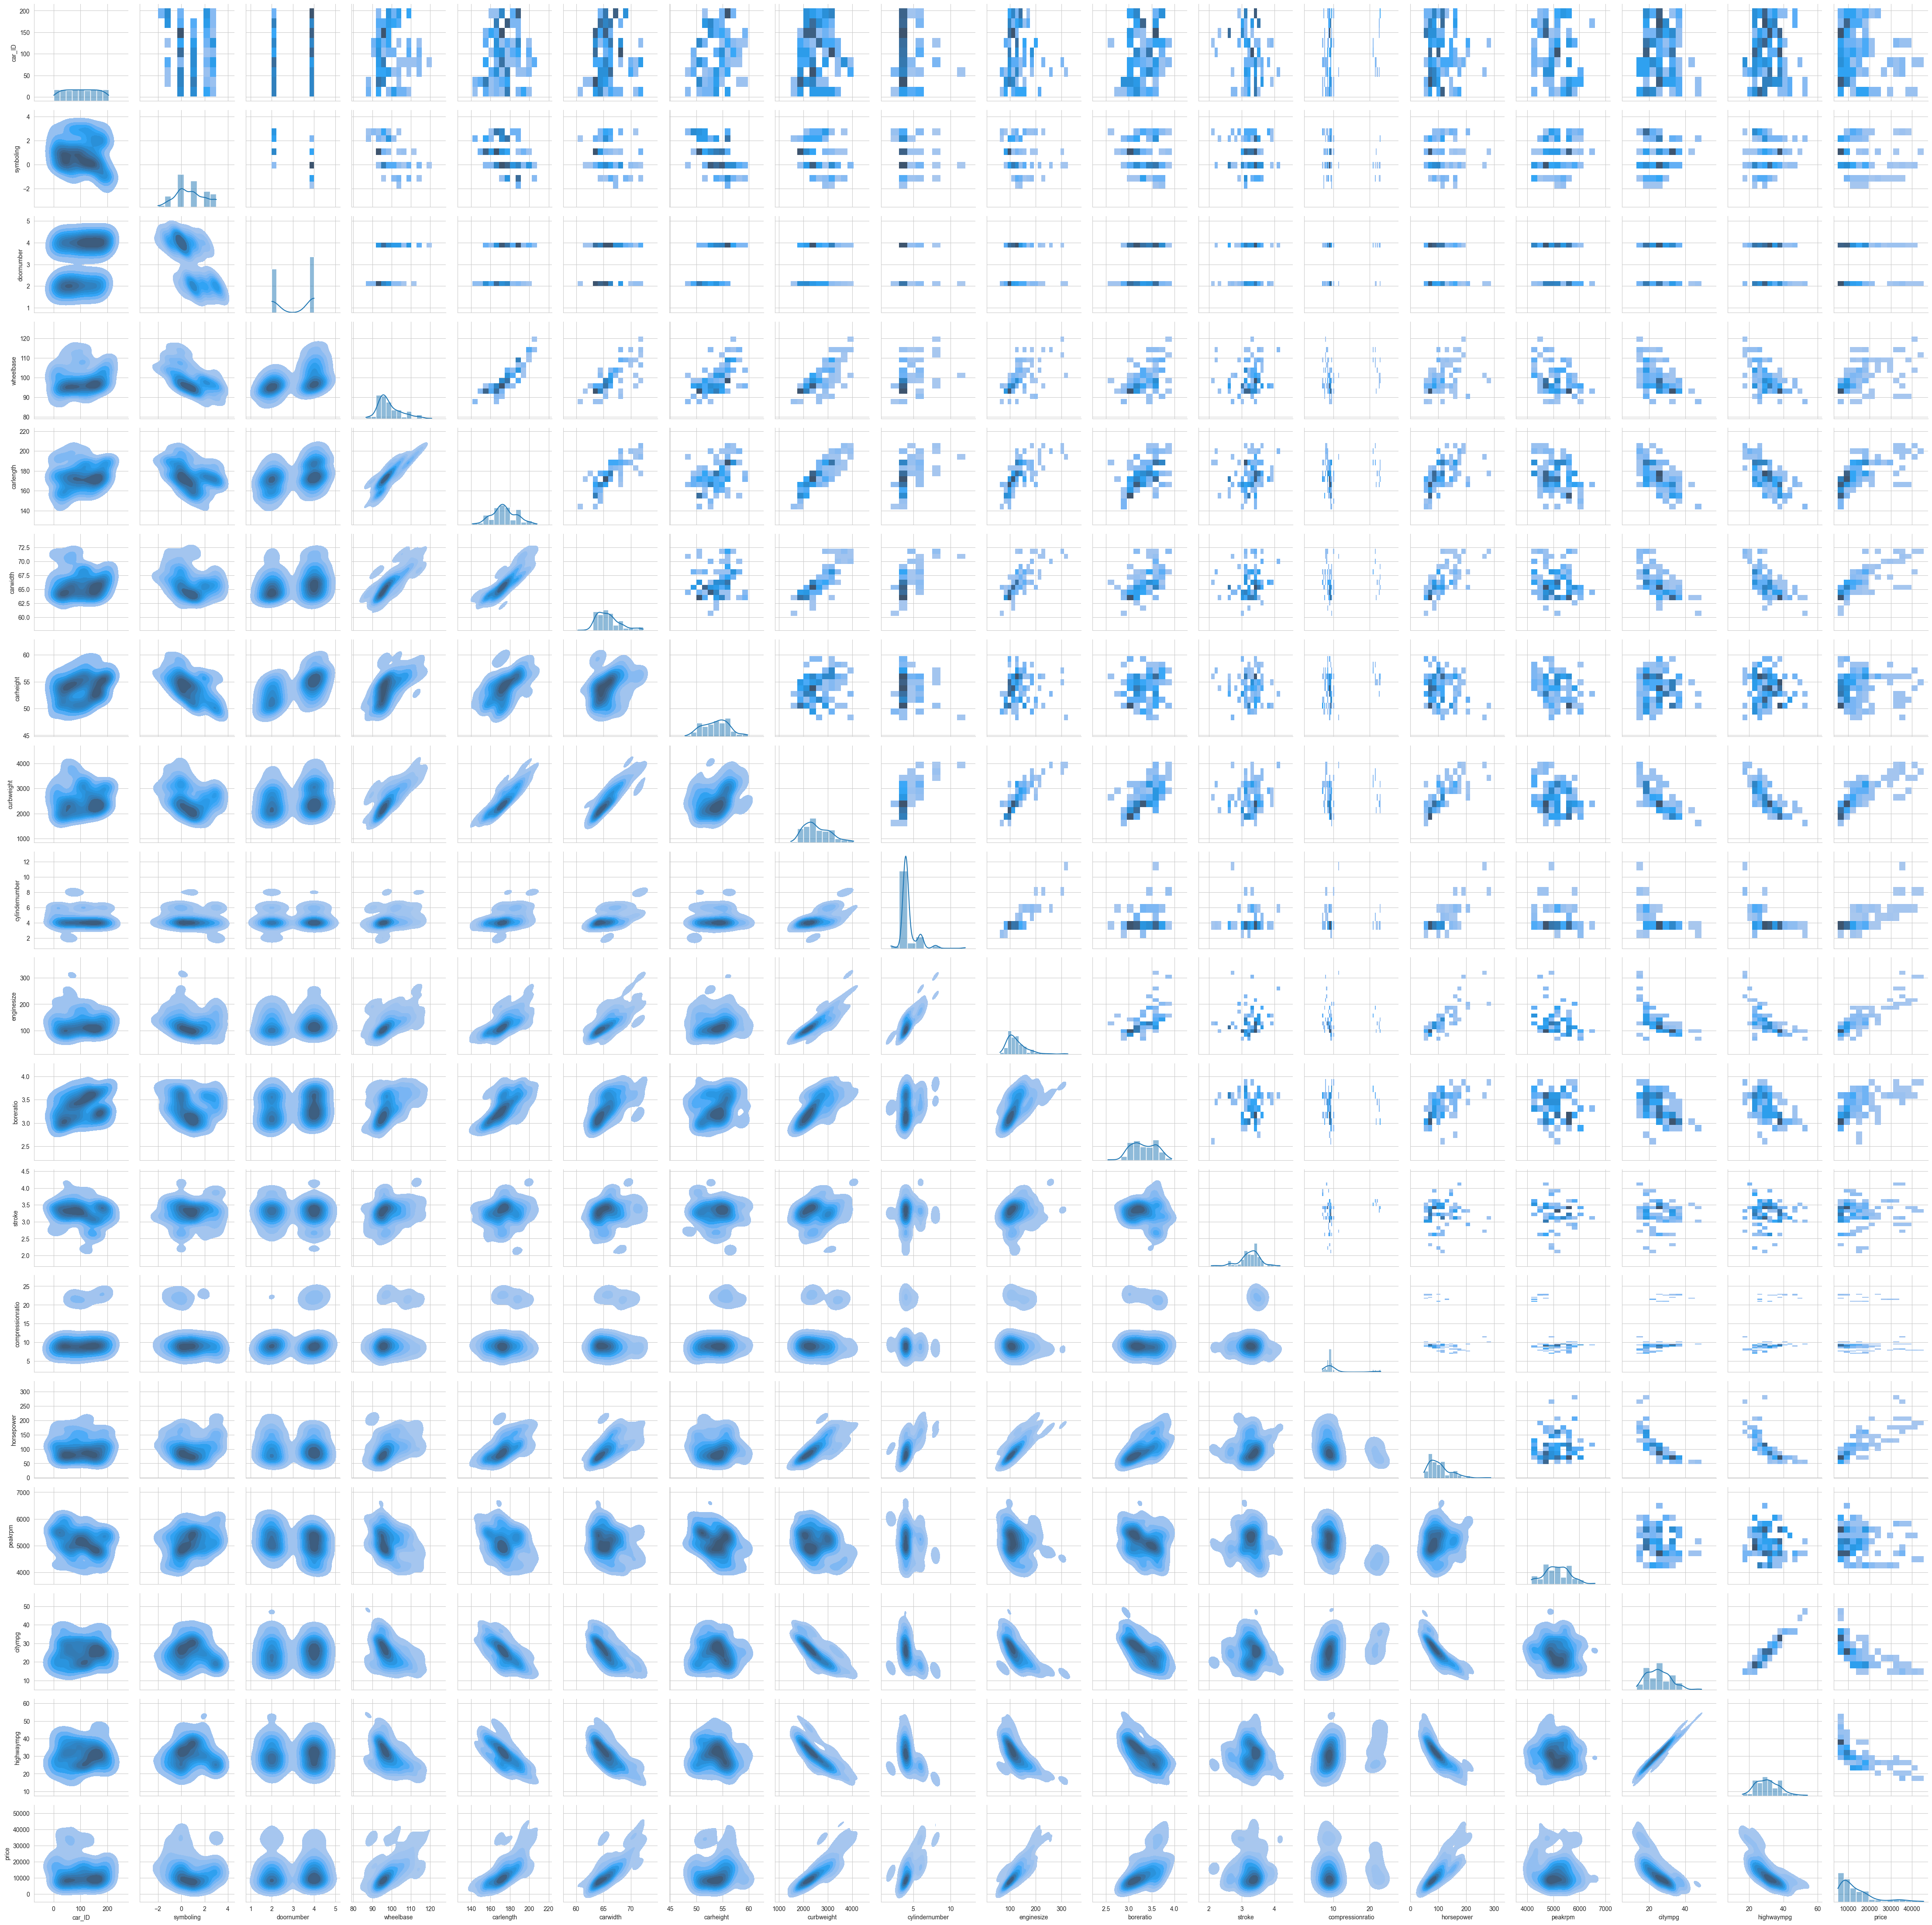

In [118]:
g=sns.PairGrid(df)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot,fill=True)
g.map_diag(sns.histplot,kde=True)

<AxesSubplot:>

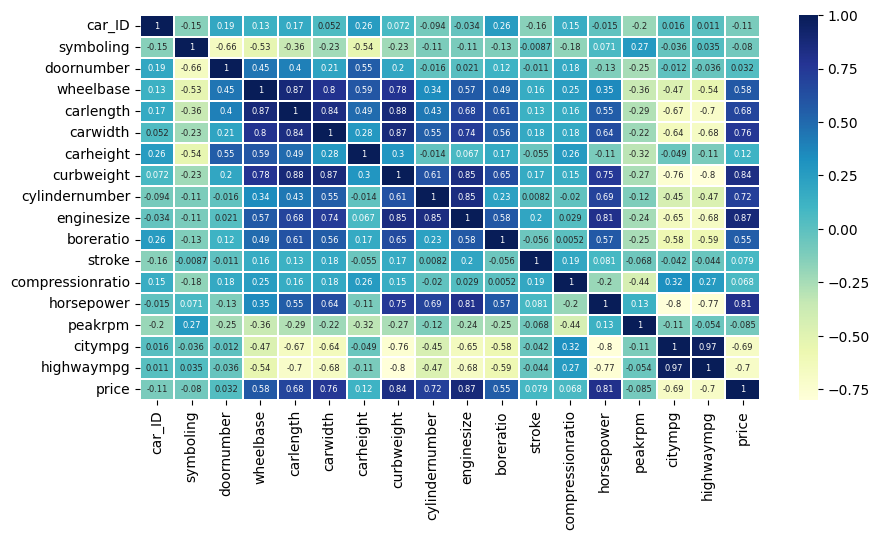

In [35]:
num_col=[col for col in df.columns if df[col].dtype !='object']
num_df=df[num_col]
plt.figure(figsize=(10,5))
sns.heatmap(num_df.corr(),annot=True,linewidths=1.3,annot_kws={"size":6},cmap='YlGnBu')

## DATA PREPROCESSING

In [36]:
X=df.iloc[:,3:-1]
y=df.iloc[:,-1]

In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=True)

In [38]:
X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)

In [39]:
X_train.columns

Index(['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
       'enginelocation', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg'],
      dtype='object')

In [40]:
X_train['fuelsystem'].unique()

array(['idi', 'mpfi', '2bbl', '1bbl', 'mfi', '4bbl', 'spdi', 'spfi'],
      dtype=object)

In [41]:
cat_col=['fueltype','aspiration','carbody','drivewheel','enginelocation','enginetype',
         'fuelsystem']


enc=OneHotEncoder(drop='first',handle_unknown='ignore')
ohe_train=pd.DataFrame(enc.fit_transform(X_train[cat_col]).toarray())
ohe_test=pd.DataFrame(enc.transform(X_test[cat_col]).toarray())
X_train=X_train.join(ohe_train)
X_test=X_test.join(ohe_test)

In [42]:
col_obj=[col for col in X_train.columns if X_train[col].dtype == 'object']

In [43]:
X_train.drop(columns=col_obj,inplace=True)
X_test.drop(columns=col_obj,inplace=True)

## BASELINE MODEL

In [164]:
scaler=MinMaxScaler()
X_train_baseline=scaler.fit_transform(X_train)
X_test_baseline=scaler.transform(X_test)


In [166]:
model=LinearRegression()
model.fit(X_train_baseline,y_train)
model_pred=model.predict(X_test_baseline)
baseline_evaluation=evaluation_regression(model_pred,y_test)

mse:13566715.983375441
rmse:3683.302320387975
mae:2328.0570445188937
r_squared:0.8332700897486002


## PARTIAL LEAST SQUARED METHOD

In [167]:
X_train_pls=X_train.copy()
X_test_pls=X_test.copy()

In [168]:
scaler=MinMaxScaler()
X_train_pls=scaler.fit_transform(X_train_pls)
X_test_pls=scaler.transform(X_test_pls)

Text(0.5, 1.0, 'hp')

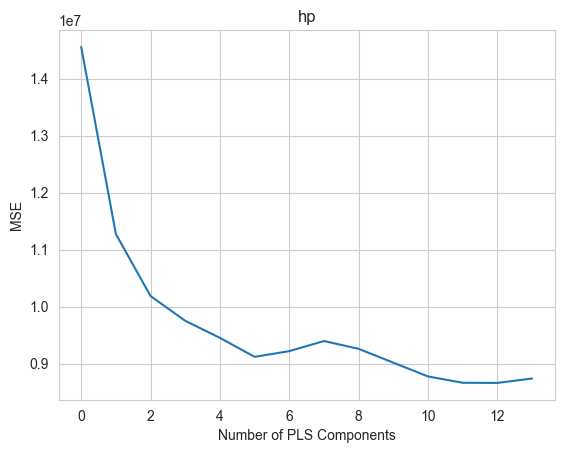

In [170]:
cv=RepeatedKFold(n_splits=10,n_repeats=3,random_state=42)
mse=[]
for i in np.arange(1,15):
    pls=PLSRegression(n_components=i)
    score=-1*cross_val_score(pls,X_train_pls,y_train,cv=cv,
                             scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')



In [171]:
pls=PLSRegression(n_components=11)
pls.fit(X_train_pls,y_train)
predict_pls=pls.predict(X_test_pls)
pls_evaluation=evaluation_regression(predict_pls,y_test)

mse:14352501.64586403
rmse:3788.4695651231027
mae:2345.908525655357
r_squared:0.8112441224109377


## BINNING  METHOD

In [50]:
X_train_bin=X_train.copy()
X_test_bin=X_test.copy()

## FEATURE BINNING

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    int64  
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    int64  
 16  enginesize        205 non-null    int64  
 1

In [52]:
#feature binning

#wheelbase binning
X_train_bin['wheelbase']=pd.qcut(X_train_bin['wheelbase'],q=3,labels=[1,2,3])
X_test_bin['wheelbase']=pd.qcut(X_test_bin['wheelbase'],q=3,labels=[1,2,3])

#stroke binning
X_train_bin['stroke']=pd.qcut(X_train_bin['stroke'],q=3,labels=[1,2,3])
X_test_bin['stroke']=pd.qcut(X_test_bin['stroke'],q=3,labels=[1,2,3])

#horsepower binning
X_train_bin['horsepower']= pd.qcut(X_train_bin['horsepower'],q=4,labels=[1,2,3,4])
X_test_bin['horsepower'] = pd.qcut(X_test_bin['horsepower'],q=4,labels=[1,2,3,4])

#citympg binning
X_train_bin['citympg']=X_train_bin['citympg']//10
X_test_bin['citympg']=X_test_bin['citympg']//10



In [54]:
X_train.columns

Index([      'doornumber',        'wheelbase',        'carlength',
               'carwidth',        'carheight',       'curbweight',
         'cylindernumber',       'enginesize',        'boreratio',
                 'stroke', 'compressionratio',       'horsepower',
                'peakrpm',          'citympg',       'highwaympg',
                        0,                  1,                  2,
                        3,                  4,                  5,
                        6,                  7,                  8,
                        9,                 10,                 11,
                       12,                 13,                 14,
                       15,                 16,                 17,
                       18,                 19,                 20,
                       21],
      dtype='object')

In [49]:
X_train_bin=scaler.fit_transform(X_train_bin)
X_test_bin=scaler.transform(X_test_bin)

In [50]:
model_bin=LinearRegression()
model_bin.fit(X_train_bin,y_train)
predict_bin=model_bin.predict(X_test_bin)
bin_evaluation=evaluation_regression(predict_bin,y_test)

mse:9633495.549763242
rmse:3103.787291320596
mae:2050.9909073503336
r_squared:0.8676648080306752


## XGBOOST BINNING METHOD

In [51]:
xgbr=xgb.XGBRegressor(n_estimators=1000,max_depth=7,eta=0.1,subsample=0.7,
                     colsample_bytree=0.8)
print(xgbr)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, ...)


In [52]:
xgbr.fit(X_train_bin,y_train)
xgb_bin_pred=xgbr.predict(X_test_bin)
xgb_bin_evaluation=evaluation_regression(xgb_bin_pred,y_test)


mse:5642712.263811802
rmse:2375.439383316653
mae:1555.9750740282013
r_squared:0.9383863348416451


## HYPER PARAMETER TUNING XGB_BINNING 

In [69]:
def objective(trial):
    param={
        'max_depth':trial.suggest_int('max_depth',1,10),
        'learning_rate':trial.suggest_float('learning_rate',0.01,1.0),
        'n_estimators':trial.suggest_int('n_estimators',50,1000),
        'min_child_weight':trial.suggest_int('min_child_weight',1,10),
        'gamma':trial.suggest_float('gamma',0.01,1.0),
        'subsample':trial.suggest_float('subsample',0.01,1),
        'colsample_bytree':trial.suggest_float('colsample_bytree',0.01,1),
        'reg_alpha':trial.suggest_float('reg_alpha',0.01,1),
        'reg_lamda':trial.suggest_float('reg_lambda',0.01,1),
        'random_state':42
        
    }
    
    xgbr_bin=xgb.XGBRegressor(**param)
    xgbr_bin.fit(X_train_bin,y_train)
    xgbr_pred=xgbr_bin.predict(X_test_bin)
    return mean_squared_error(xgbr_pred,y_test)
    

In [70]:
study=optuna.create_study(direction='minimize',study_name='regression')
study.optimize(objective,n_trials=100)

[I 2022-11-26 17:37:02,579] A new study created in memory with name: regression


[17:37:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:03,073] Trial 0 finished with value: 11824503.350625541 and parameters: {'max_depth': 2, 'learning_rate': 0.262833755470022, 'n_estimators': 952, 'min_child_weight': 8, 'gamma': 0.7783286782647126, 'subsample': 0.1958461986154753, 'colsample_bytree': 0.32687869123752106, 'reg_alpha': 0.30369450696690065, 'reg_lambda': 0.6379889376441553}. Best is trial 0 with value: 11824503.350625541.


[17:37:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:03,308] Trial 1 finished with value: 5788216.528608132 and parameters: {'max_depth': 1, 'learning_rate': 0.03340306096895601, 'n_estimators': 469, 'min_child_weight': 6, 'gamma': 0.275779643650096, 'subsample': 0.6580741166045256, 'colsample_bytree': 0.8427835097950642, 'reg_alpha': 0.772363978023576, 'reg_lambda': 0.32508828492554115}. Best is trial 1 with value: 5788216.528608132.


[17:37:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:04,195] Trial 2 finished with value: 11925931.274493774 and parameters: {'max_depth': 7, 'learning_rate': 0.8426595759155218, 'n_estimators': 794, 'min_child_weight': 4, 'gamma': 0.8983018045316372, 'subsample': 0.9087242367669985, 'colsample_bytree': 0.902267700734306, 'reg_alpha': 0.5176967525950795, 'reg_lambda': 0.87262651997052}. Best is trial 1 with value: 5788216.528608132.
[I 2022-11-26 17:37:04,278] Trial 3 finished with value: 25510172.84814357 and parameters: {'max_depth': 5, 'learning_rate': 0.4097586228287781, 'n_estimators': 142, 'min_child_weight': 4, 'gamma': 0.9807719960881234, 'subsample': 0.05718196646601536, 'colsample_bytree': 0.3663755333211842, 'reg_alpha': 0.7336701459487364, 'reg_lambda': 0.5433402941433}. Best is trial 1 with value: 5788216.528608132.


[17:37:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:37:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:04,549] Trial 4 finished with value: 4393090.380203481 and parameters: {'max_depth': 6, 'learning_rate': 0.16626139697393966, 'n_estimators': 299, 'min_child_weight': 7, 'gamma': 0.8622845824377833, 'subsample': 0.9528414140405558, 'colsample_bytree': 0.5693880446738383, 'reg_alpha': 0.9847571428898747, 'reg_lambda': 0.6230467141915057}. Best is trial 4 with value: 4393090.380203481.


[17:37:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:04,842] Trial 5 finished with value: 6587754.631920787 and parameters: {'max_depth': 5, 'learning_rate': 0.5760060724483831, 'n_estimators': 379, 'min_child_weight': 6, 'gamma': 0.041564664101333734, 'subsample': 0.5256191192123815, 'colsample_bytree': 0.3366709213270587, 'reg_alpha': 0.13226401538955862, 'reg_lambda': 0.20130432337753734}. Best is trial 4 with value: 4393090.380203481.


[17:37:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:05,090] Trial 6 finished with value: 5976668.605155957 and parameters: {'max_depth': 4, 'learning_rate': 0.4245561638288712, 'n_estimators': 340, 'min_child_weight': 3, 'gamma': 0.5625517267303649, 'subsample': 0.6493580807241974, 'colsample_bytree': 0.2449733155665863, 'reg_alpha': 0.18563363732291813, 'reg_lambda': 0.843028289332812}. Best is trial 4 with value: 4393090.380203481.


[17:37:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:05,540] Trial 7 finished with value: 7075462.58441677 and parameters: {'max_depth': 9, 'learning_rate': 0.610803453865936, 'n_estimators': 526, 'min_child_weight': 8, 'gamma': 0.8153353332731387, 'subsample': 0.5437192144654059, 'colsample_bytree': 0.4208537025014542, 'reg_alpha': 0.36316373169306554, 'reg_lambda': 0.6077293159640874}. Best is trial 4 with value: 4393090.380203481.


[17:37:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:06,140] Trial 8 finished with value: 6406158.617207129 and parameters: {'max_depth': 7, 'learning_rate': 0.4243540947767908, 'n_estimators': 585, 'min_child_weight': 2, 'gamma': 0.9673999545722289, 'subsample': 0.4845210228017544, 'colsample_bytree': 0.5032763973859748, 'reg_alpha': 0.8530655718738189, 'reg_lambda': 0.8209438662094098}. Best is trial 4 with value: 4393090.380203481.


[17:37:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:06,601] Trial 9 finished with value: 10154053.453143736 and parameters: {'max_depth': 10, 'learning_rate': 0.7309952228737536, 'n_estimators': 387, 'min_child_weight': 2, 'gamma': 0.37035371556506336, 'subsample': 0.43363026627333207, 'colsample_bytree': 0.3529550331398509, 'reg_alpha': 0.2931084908071325, 'reg_lambda': 0.9044669327248106}. Best is trial 4 with value: 4393090.380203481.
[I 2022-11-26 17:37:06,697] Trial 10 finished with value: 90723313.71951132 and parameters: {'max_depth': 3, 'learning_rate': 0.013894282550178771, 'n_estimators': 64, 'min_child_weight': 10, 'gamma': 0.6240180460942537, 'subsample': 0.9966512218722283, 'colsample_bytree': 0.04696057155126532, 'reg_alpha': 0.9768548275189912, 'reg_lambda': 0.04917749275886463}. Best is trial 4 with value: 4393090.380203481.


[17:37:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:37:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:06,863] Trial 11 finished with value: 6185569.368218743 and parameters: {'max_depth': 1, 'learning_rate': 0.025506685579493763, 'n_estimators': 239, 'min_child_weight': 6, 'gamma': 0.24788077976384426, 'subsample': 0.7849227746989001, 'colsample_bytree': 0.7921253169598149, 'reg_alpha': 0.6978456142189225, 'reg_lambda': 0.30950716789215976}. Best is trial 4 with value: 4393090.380203481.


[17:37:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:07,537] Trial 12 finished with value: 5105659.75738252 and parameters: {'max_depth': 7, 'learning_rate': 0.20162769985732215, 'n_estimators': 633, 'min_child_weight': 7, 'gamma': 0.30267264039042885, 'subsample': 0.7753263797724063, 'colsample_bytree': 0.6846368983843811, 'reg_alpha': 0.9968078263141658, 'reg_lambda': 0.38226357393124555}. Best is trial 4 with value: 4393090.380203481.


[17:37:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:08,247] Trial 13 finished with value: 5438768.336170334 and parameters: {'max_depth': 7, 'learning_rate': 0.20243700117665184, 'n_estimators': 670, 'min_child_weight': 8, 'gamma': 0.41704162143740225, 'subsample': 0.8347467939043676, 'colsample_bytree': 0.6715285917412515, 'reg_alpha': 0.9929901956602843, 'reg_lambda': 0.4249698786899389}. Best is trial 4 with value: 4393090.380203481.


[17:37:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:09,051] Trial 14 finished with value: 3723511.0557435052 and parameters: {'max_depth': 8, 'learning_rate': 0.238668559593119, 'n_estimators': 728, 'min_child_weight': 10, 'gamma': 0.06945146171021652, 'subsample': 0.9965175969233802, 'colsample_bytree': 0.6512900365905597, 'reg_alpha': 0.5695933768466785, 'reg_lambda': 0.7367199028866276}. Best is trial 14 with value: 3723511.0557435052.


[17:37:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:09,973] Trial 15 finished with value: 5043429.380578837 and parameters: {'max_depth': 9, 'learning_rate': 0.26781542956013626, 'n_estimators': 799, 'min_child_weight': 10, 'gamma': 0.023938385577952727, 'subsample': 0.9756083192990627, 'colsample_bytree': 0.6253309921135893, 'reg_alpha': 0.5904614721866325, 'reg_lambda': 0.7137133362953941}. Best is trial 14 with value: 3723511.0557435052.


[17:37:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:10,633] Trial 16 finished with value: 7744284.187378267 and parameters: {'max_depth': 8, 'learning_rate': 0.1459390114521595, 'n_estimators': 995, 'min_child_weight': 9, 'gamma': 0.6762954094104946, 'subsample': 0.26252525161711926, 'colsample_bytree': 0.5572131171136154, 'reg_alpha': 0.047583625978117605, 'reg_lambda': 0.7020422627413798}. Best is trial 14 with value: 3723511.0557435052.


[17:37:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:11,340] Trial 17 finished with value: 5757800.803584743 and parameters: {'max_depth': 5, 'learning_rate': 0.3291071353592955, 'n_estimators': 802, 'min_child_weight': 9, 'gamma': 0.13683934205615894, 'subsample': 0.8726931255803299, 'colsample_bytree': 0.7934930698314845, 'reg_alpha': 0.6203974815388124, 'reg_lambda': 0.9766686155183446}. Best is trial 14 with value: 3723511.0557435052.


[17:37:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:11,659] Trial 18 finished with value: 5612320.453710215 and parameters: {'max_depth': 6, 'learning_rate': 0.12322954869320579, 'n_estimators': 253, 'min_child_weight': 5, 'gamma': 0.4848713774627864, 'subsample': 0.6857128963378126, 'colsample_bytree': 0.981679326602636, 'reg_alpha': 0.41935007063082896, 'reg_lambda': 0.5022347160502038}. Best is trial 14 with value: 3723511.0557435052.


[17:37:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:12,569] Trial 19 finished with value: 7873146.930355679 and parameters: {'max_depth': 10, 'learning_rate': 0.35113068898159383, 'n_estimators': 730, 'min_child_weight': 7, 'gamma': 0.7292002503733049, 'subsample': 0.9998373360160488, 'colsample_bytree': 0.49178302074657465, 'reg_alpha': 0.8639236120185768, 'reg_lambda': 0.7534966328742584}. Best is trial 14 with value: 3723511.0557435052.


[17:37:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:13,044] Trial 20 finished with value: 11937790.756338751 and parameters: {'max_depth': 8, 'learning_rate': 0.9784856318990318, 'n_estimators': 447, 'min_child_weight': 10, 'gamma': 0.15734603335872474, 'subsample': 0.7355677383568139, 'colsample_bytree': 0.725802569231952, 'reg_alpha': 0.47168101406899154, 'reg_lambda': 0.5164680028858577}. Best is trial 14 with value: 3723511.0557435052.


[17:37:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:13,991] Trial 21 finished with value: 4494333.27078448 and parameters: {'max_depth': 9, 'learning_rate': 0.2866551433289731, 'n_estimators': 902, 'min_child_weight': 10, 'gamma': 0.07283736329507245, 'subsample': 0.8992599749675336, 'colsample_bytree': 0.5811180010028207, 'reg_alpha': 0.5889872677326891, 'reg_lambda': 0.6945125106842568}. Best is trial 14 with value: 3723511.0557435052.


[17:37:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:14,985] Trial 22 finished with value: 4332960.373177696 and parameters: {'max_depth': 9, 'learning_rate': 0.13515592517454886, 'n_estimators': 923, 'min_child_weight': 9, 'gamma': 0.13690685159986865, 'subsample': 0.914781581412553, 'colsample_bytree': 0.5805757273438933, 'reg_alpha': 0.5717375478402968, 'reg_lambda': 0.6491136672032264}. Best is trial 14 with value: 3723511.0557435052.


[17:37:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:15,853] Trial 23 finished with value: 3705361.0545991417 and parameters: {'max_depth': 8, 'learning_rate': 0.13602083671380666, 'n_estimators': 860, 'min_child_weight': 9, 'gamma': 0.19851788568895054, 'subsample': 0.9107359831597208, 'colsample_bytree': 0.475244095862343, 'reg_alpha': 0.8594087600463598, 'reg_lambda': 0.6109696951120412}. Best is trial 23 with value: 3705361.0545991417.


[17:37:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:16,665] Trial 24 finished with value: 3824476.499031918 and parameters: {'max_depth': 8, 'learning_rate': 0.10698655505486399, 'n_estimators': 884, 'min_child_weight': 9, 'gamma': 0.17260416993770064, 'subsample': 0.8782081024550921, 'colsample_bytree': 0.21623387224991358, 'reg_alpha': 0.8554608810370212, 'reg_lambda': 0.5528104871797943}. Best is trial 23 with value: 3705361.0545991417.


[17:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:17,428] Trial 25 finished with value: 3303005.4046010813 and parameters: {'max_depth': 8, 'learning_rate': 0.0910649357584079, 'n_estimators': 865, 'min_child_weight': 9, 'gamma': 0.20908809832546404, 'subsample': 0.8140588114284764, 'colsample_bytree': 0.20512545012403888, 'reg_alpha': 0.8617430286537547, 'reg_lambda': 0.7939310623228673}. Best is trial 25 with value: 3303005.4046010813.


[17:37:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:18,040] Trial 26 finished with value: 3810082.3987724157 and parameters: {'max_depth': 8, 'learning_rate': 0.07175545790367263, 'n_estimators': 714, 'min_child_weight': 8, 'gamma': 0.20916716677920902, 'subsample': 0.8096020857385082, 'colsample_bytree': 0.11498287247612, 'reg_alpha': 0.795742237697176, 'reg_lambda': 0.7671171140895668}. Best is trial 25 with value: 3303005.4046010813.


[17:37:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:19,272] Trial 27 finished with value: 5672490.049052441 and parameters: {'max_depth': 10, 'learning_rate': 0.5256615683975036, 'n_estimators': 843, 'min_child_weight': 1, 'gamma': 0.3300731169753065, 'subsample': 0.6436646477149617, 'colsample_bytree': 0.4435984429720566, 'reg_alpha': 0.6863084452150282, 'reg_lambda': 0.973245459301356}. Best is trial 25 with value: 3303005.4046010813.


[17:37:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:19,798] Trial 28 finished with value: 6899498.828206213 and parameters: {'max_depth': 6, 'learning_rate': 0.1915686986987989, 'n_estimators': 753, 'min_child_weight': 9, 'gamma': 0.40585554062088314, 'subsample': 0.36771828588025396, 'colsample_bytree': 0.21207267089592063, 'reg_alpha': 0.8883845882077696, 'reg_lambda': 0.7887825156695272}. Best is trial 25 with value: 3303005.4046010813.


[17:37:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:20,358] Trial 29 finished with value: 6021203.385336899 and parameters: {'max_depth': 8, 'learning_rate': 0.23682654785716634, 'n_estimators': 995, 'min_child_weight': 8, 'gamma': 0.07551928203277075, 'subsample': 0.7216186714443947, 'colsample_bytree': 0.020624936454508858, 'reg_alpha': 0.6660205698992829, 'reg_lambda': 0.9141594355013066}. Best is trial 25 with value: 3303005.4046010813.


[17:37:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:20,864] Trial 30 finished with value: 4968405.2218862455 and parameters: {'max_depth': 7, 'learning_rate': 0.3339040333820209, 'n_estimators': 631, 'min_child_weight': 10, 'gamma': 0.46517630840115265, 'subsample': 0.6015558370029548, 'colsample_bytree': 0.2751824560413469, 'reg_alpha': 0.79532025349043, 'reg_lambda': 0.654572133311543}. Best is trial 25 with value: 3303005.4046010813.


[17:37:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:21,466] Trial 31 finished with value: 4031508.849505154 and parameters: {'max_depth': 8, 'learning_rate': 0.0740993119490504, 'n_estimators': 720, 'min_child_weight': 8, 'gamma': 0.2165580105003976, 'subsample': 0.8240445894161172, 'colsample_bytree': 0.11611483864190963, 'reg_alpha': 0.917230477762751, 'reg_lambda': 0.7698326249885474}. Best is trial 25 with value: 3303005.4046010813.


[17:37:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:22,256] Trial 32 finished with value: 3180601.7502441034 and parameters: {'max_depth': 9, 'learning_rate': 0.08566831112130854, 'n_estimators': 852, 'min_child_weight': 9, 'gamma': 0.22741027675140094, 'subsample': 0.8150500853297444, 'colsample_bytree': 0.1640486288934544, 'reg_alpha': 0.7807733479247736, 'reg_lambda': 0.7443105859611008}. Best is trial 32 with value: 3180601.7502441034.


[17:37:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:22,912] Trial 33 finished with value: 3394794.750737948 and parameters: {'max_depth': 9, 'learning_rate': 0.07596440622177142, 'n_estimators': 868, 'min_child_weight': 9, 'gamma': 0.10552767706059694, 'subsample': 0.9294029528250302, 'colsample_bytree': 0.14743199154177147, 'reg_alpha': 0.791589553388341, 'reg_lambda': 0.8418086061091805}. Best is trial 32 with value: 3180601.7502441034.


[17:37:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:23,651] Trial 34 finished with value: 5939986.268533642 and parameters: {'max_depth': 9, 'learning_rate': 0.015996344544074052, 'n_estimators': 867, 'min_child_weight': 7, 'gamma': 0.26115976854876394, 'subsample': 0.7529899223732712, 'colsample_bytree': 0.15170907185871674, 'reg_alpha': 0.741778366118822, 'reg_lambda': 0.8756558083312701}. Best is trial 32 with value: 3180601.7502441034.


[17:37:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:24,550] Trial 35 finished with value: 3554680.847530019 and parameters: {'max_depth': 10, 'learning_rate': 0.09598729032232549, 'n_estimators': 944, 'min_child_weight': 9, 'gamma': 0.33022032214780517, 'subsample': 0.925151593566162, 'colsample_bytree': 0.17184536519484236, 'reg_alpha': 0.9199711833508506, 'reg_lambda': 0.8242961744779504}. Best is trial 32 with value: 3180601.7502441034.


[17:37:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:25,381] Trial 36 finished with value: 4814192.890929707 and parameters: {'max_depth': 10, 'learning_rate': 0.0921486862526578, 'n_estimators': 942, 'min_child_weight': 8, 'gamma': 0.3371893584289091, 'subsample': 0.8435860779983001, 'colsample_bytree': 0.16117898589724877, 'reg_alpha': 0.9329098218533147, 'reg_lambda': 0.9304077604859275}. Best is trial 32 with value: 3180601.7502441034.


[17:37:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:26,454] Trial 37 finished with value: 6212840.987191754 and parameters: {'max_depth': 10, 'learning_rate': 0.06468954719244528, 'n_estimators': 959, 'min_child_weight': 5, 'gamma': 0.1147371994192494, 'subsample': 0.9226366153418636, 'colsample_bytree': 0.2885235199322207, 'reg_alpha': 0.8012171451837397, 'reg_lambda': 0.8261641941269011}. Best is trial 32 with value: 3180601.7502441034.


[17:37:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:26,900] Trial 38 finished with value: 15903915.337826712 and parameters: {'max_depth': 9, 'learning_rate': 0.06761044969039931, 'n_estimators': 822, 'min_child_weight': 7, 'gamma': 0.2585578443769507, 'subsample': 0.14733340774029607, 'colsample_bytree': 0.07470387861243012, 'reg_alpha': 0.7762582507352693, 'reg_lambda': 0.8593827766760105}. Best is trial 32 with value: 3180601.7502441034.


[17:37:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:27,656] Trial 39 finished with value: 6758597.973131211 and parameters: {'max_depth': 10, 'learning_rate': 0.17684334984640804, 'n_estimators': 782, 'min_child_weight': 6, 'gamma': 0.5331042800309027, 'subsample': 0.9403089427594594, 'colsample_bytree': 0.18002892386375177, 'reg_alpha': 0.9219796800946398, 'reg_lambda': 0.8081468759699109}. Best is trial 32 with value: 3180601.7502441034.


[17:37:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:28,145] Trial 40 finished with value: 7975406.053175411 and parameters: {'max_depth': 9, 'learning_rate': 0.7269302365360814, 'n_estimators': 547, 'min_child_weight': 9, 'gamma': 0.2928980871669074, 'subsample': 0.6925545904490091, 'colsample_bytree': 0.2948237828141521, 'reg_alpha': 0.7313757430122853, 'reg_lambda': 0.9508850199700332}. Best is trial 32 with value: 3180601.7502441034.


[17:37:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:29,098] Trial 41 finished with value: 4492304.080736762 and parameters: {'max_depth': 9, 'learning_rate': 0.14146945712780187, 'n_estimators': 870, 'min_child_weight': 9, 'gamma': 0.2019474303016187, 'subsample': 0.8731703845560083, 'colsample_bytree': 0.3869884121571412, 'reg_alpha': 0.834677677148632, 'reg_lambda': 0.5688891268623033}. Best is trial 32 with value: 3180601.7502441034.


[17:37:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:29,833] Trial 42 finished with value: 5333055.42269614 and parameters: {'max_depth': 10, 'learning_rate': 0.1047323283898674, 'n_estimators': 944, 'min_child_weight': 8, 'gamma': 0.18760407746962315, 'subsample': 0.9412999491166724, 'colsample_bytree': 0.08524858679419739, 'reg_alpha': 0.9397118620806815, 'reg_lambda': 0.5977525575438281}. Best is trial 32 with value: 3180601.7502441034.


[17:37:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:30,592] Trial 43 finished with value: 3565277.917134946 and parameters: {'max_depth': 7, 'learning_rate': 0.04697614431413966, 'n_estimators': 841, 'min_child_weight': 9, 'gamma': 0.01176123100470762, 'subsample': 0.7927572661449835, 'colsample_bytree': 0.2428216459207686, 'reg_alpha': 0.8258992247633464, 'reg_lambda': 0.6653953325079468}. Best is trial 32 with value: 3180601.7502441034.


[17:37:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:31,355] Trial 44 finished with value: 4428161.647403543 and parameters: {'max_depth': 7, 'learning_rate': 0.06602492500817542, 'n_estimators': 904, 'min_child_weight': 10, 'gamma': 0.010218254019154343, 'subsample': 0.6189064857117131, 'colsample_bytree': 0.2567741557945075, 'reg_alpha': 0.7308121750507466, 'reg_lambda': 0.8903277636953691}. Best is trial 32 with value: 3180601.7502441034.


[17:37:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:31,975] Trial 45 finished with value: 4183407.4293143516 and parameters: {'max_depth': 6, 'learning_rate': 0.02138418431346695, 'n_estimators': 773, 'min_child_weight': 9, 'gamma': 0.09690548728288534, 'subsample': 0.7838055959648834, 'colsample_bytree': 0.20825694887306784, 'reg_alpha': 0.6550452444930512, 'reg_lambda': 0.6785899777868748}. Best is trial 32 with value: 3180601.7502441034.


[17:37:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:32,825] Trial 46 finished with value: 4841275.739784945 and parameters: {'max_depth': 7, 'learning_rate': 0.2244014051843088, 'n_estimators': 673, 'min_child_weight': 8, 'gamma': 0.049222610404383166, 'subsample': 0.8447169946016256, 'colsample_bytree': 0.3319919882883511, 'reg_alpha': 0.8189674103863599, 'reg_lambda': 0.8392310865214418}. Best is trial 32 with value: 3180601.7502441034.


[17:37:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:33,672] Trial 47 finished with value: 5818940.606871944 and parameters: {'max_depth': 9, 'learning_rate': 0.4567896958069759, 'n_estimators': 961, 'min_child_weight': 7, 'gamma': 0.11406989510346796, 'subsample': 0.7969087482764091, 'colsample_bytree': 0.11186764592817819, 'reg_alpha': 0.8922401859260815, 'reg_lambda': 0.9980381587315614}. Best is trial 32 with value: 3180601.7502441034.


[17:37:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:34,196] Trial 48 finished with value: 7566175.416802319 and parameters: {'max_depth': 3, 'learning_rate': 0.1769183784924407, 'n_estimators': 827, 'min_child_weight': 4, 'gamma': 0.37104475210452265, 'subsample': 0.591584491496611, 'colsample_bytree': 0.05656248932740095, 'reg_alpha': 0.9475748814296387, 'reg_lambda': 0.023434615942801773}. Best is trial 32 with value: 3180601.7502441034.


[17:37:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:34,701] Trial 49 finished with value: 6271977.855888064 and parameters: {'max_depth': 4, 'learning_rate': 0.30091705707253225, 'n_estimators': 831, 'min_child_weight': 10, 'gamma': 0.26264736034904435, 'subsample': 0.697517240631875, 'colsample_bytree': 0.014042106668851612, 'reg_alpha': 0.4996647111601524, 'reg_lambda': 0.737747537770093}. Best is trial 32 with value: 3180601.7502441034.


[17:37:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:35,590] Trial 50 finished with value: 3826614.251786158 and parameters: {'max_depth': 9, 'learning_rate': 0.03502390439402466, 'n_estimators': 910, 'min_child_weight': 8, 'gamma': 0.23268920663313325, 'subsample': 0.5556119954192688, 'colsample_bytree': 0.3948816452787125, 'reg_alpha': 0.7388968837102353, 'reg_lambda': 0.21426164183290658}. Best is trial 32 with value: 3180601.7502441034.


[17:37:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:36,425] Trial 51 finished with value: 4183111.802970382 and parameters: {'max_depth': 8, 'learning_rate': 0.13913544242181236, 'n_estimators': 858, 'min_child_weight': 9, 'gamma': 0.15767501638933507, 'subsample': 0.9469368664200617, 'colsample_bytree': 0.17949744513468974, 'reg_alpha': 0.8578806834389936, 'reg_lambda': 0.6642225934098199}. Best is trial 32 with value: 3180601.7502441034.


[17:37:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:37,286] Trial 52 finished with value: 3874489.024399128 and parameters: {'max_depth': 8, 'learning_rate': 0.10973429218786104, 'n_estimators': 875, 'min_child_weight': 9, 'gamma': 0.04858253310071844, 'subsample': 0.8621704877097814, 'colsample_bytree': 0.24312103383176528, 'reg_alpha': 0.8873046495484881, 'reg_lambda': 0.616686090368569}. Best is trial 32 with value: 3180601.7502441034.


[17:37:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:38,148] Trial 53 finished with value: 2892906.949743409 and parameters: {'max_depth': 7, 'learning_rate': 0.0440157629354711, 'n_estimators': 983, 'min_child_weight': 10, 'gamma': 0.32642270449571775, 'subsample': 0.9014393554298459, 'colsample_bytree': 0.14266794078971815, 'reg_alpha': 0.25389467661993276, 'reg_lambda': 0.7161584247550323}. Best is trial 53 with value: 2892906.949743409.


[17:37:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:39,005] Trial 54 finished with value: 3196468.751580551 and parameters: {'max_depth': 7, 'learning_rate': 0.055276908945337225, 'n_estimators': 999, 'min_child_weight': 10, 'gamma': 0.32430848813002944, 'subsample': 0.7588130729575943, 'colsample_bytree': 0.14439139088731498, 'reg_alpha': 0.2579716965725346, 'reg_lambda': 0.7987140930468002}. Best is trial 53 with value: 2892906.949743409.


[17:37:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:39,513] Trial 55 finished with value: 115082555.62750772 and parameters: {'max_depth': 6, 'learning_rate': 0.6341907513306558, 'n_estimators': 1000, 'min_child_weight': 10, 'gamma': 0.4463409208235427, 'subsample': 0.017801800512154964, 'colsample_bytree': 0.14099256148007572, 'reg_alpha': 0.2755470132879877, 'reg_lambda': 0.7908700404684459}. Best is trial 53 with value: 2892906.949743409.


[17:37:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:40,197] Trial 56 finished with value: 3312730.143077432 and parameters: {'max_depth': 5, 'learning_rate': 0.16149074531678953, 'n_estimators': 970, 'min_child_weight': 10, 'gamma': 0.3405693033651509, 'subsample': 0.9728099896508676, 'colsample_bytree': 0.08601009867935733, 'reg_alpha': 0.25242235938468627, 'reg_lambda': 0.7301110833607495}. Best is trial 53 with value: 2892906.949743409.


[17:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:40,889] Trial 57 finished with value: 5376722.786739112 and parameters: {'max_depth': 5, 'learning_rate': 0.3758638205765434, 'n_estimators': 982, 'min_child_weight': 10, 'gamma': 0.38774539521835677, 'subsample': 0.9665309296274515, 'colsample_bytree': 0.09054142308735115, 'reg_alpha': 0.22458003130045467, 'reg_lambda': 0.7210604386683587}. Best is trial 53 with value: 2892906.949743409.


[17:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:41,403] Trial 58 finished with value: 5010160.361134985 and parameters: {'max_depth': 4, 'learning_rate': 0.20988675291957365, 'n_estimators': 916, 'min_child_weight': 10, 'gamma': 0.3027341569875208, 'subsample': 0.749582112853843, 'colsample_bytree': 0.0478629968515346, 'reg_alpha': 0.12385352942375916, 'reg_lambda': 0.47080056144972315}. Best is trial 53 with value: 2892906.949743409.


[17:37:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:42,180] Trial 59 finished with value: 3210057.1668422557 and parameters: {'max_depth': 6, 'learning_rate': 0.2587311428655942, 'n_estimators': 966, 'min_child_weight': 10, 'gamma': 0.4291438364429661, 'subsample': 0.8892091280661037, 'colsample_bytree': 0.12860916292243804, 'reg_alpha': 0.3667773031342804, 'reg_lambda': 0.8690264881154263}. Best is trial 53 with value: 2892906.949743409.


[17:37:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:42,921] Trial 60 finished with value: 7375564.479277012 and parameters: {'max_depth': 5, 'learning_rate': 0.2532331240725853, 'n_estimators': 963, 'min_child_weight': 10, 'gamma': 0.5702666869310423, 'subsample': 0.45353817681109687, 'colsample_bytree': 0.31160705976242353, 'reg_alpha': 0.3557525530002064, 'reg_lambda': 0.7490309712257665}. Best is trial 53 with value: 2892906.949743409.


[17:37:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:43,668] Trial 61 finished with value: 3556430.4098286787 and parameters: {'max_depth': 6, 'learning_rate': 0.16381057486668232, 'n_estimators': 928, 'min_child_weight': 10, 'gamma': 0.43707107609808293, 'subsample': 0.8804197861274409, 'colsample_bytree': 0.14450436332532512, 'reg_alpha': 0.3367067719634015, 'reg_lambda': 0.8862925279649514}. Best is trial 53 with value: 2892906.949743409.


[17:37:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:44,504] Trial 62 finished with value: 3753026.495752357 and parameters: {'max_depth': 6, 'learning_rate': 0.039092449468727794, 'n_estimators': 973, 'min_child_weight': 10, 'gamma': 0.355022676759512, 'subsample': 0.9941793306048475, 'colsample_bytree': 0.20753001207643362, 'reg_alpha': 0.4080800287271247, 'reg_lambda': 0.861275295881534}. Best is trial 53 with value: 2892906.949743409.


[17:37:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:45,251] Trial 63 finished with value: 2902453.948675259 and parameters: {'max_depth': 7, 'learning_rate': 0.11973340097417881, 'n_estimators': 895, 'min_child_weight': 10, 'gamma': 0.2990434609350088, 'subsample': 0.8952584383454267, 'colsample_bytree': 0.11558497465621295, 'reg_alpha': 0.31646239752873717, 'reg_lambda': 0.7931291624840285}. Best is trial 53 with value: 2892906.949743409.


[17:37:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:45,931] Trial 64 finished with value: 3471926.0571790687 and parameters: {'max_depth': 7, 'learning_rate': 0.16217918997335784, 'n_estimators': 896, 'min_child_weight': 10, 'gamma': 0.3133967405576078, 'subsample': 0.8215730887713308, 'colsample_bytree': 0.09750091897988913, 'reg_alpha': 0.25829202452746536, 'reg_lambda': 0.6956065774053314}. Best is trial 53 with value: 2892906.949743409.
[I 2022-11-26 17:37:46,061] Trial 65 finished with value: 8723239.433348818 and parameters: {'max_depth': 5, 'learning_rate': 0.11809684979116003, 'n_estimators': 114, 'min_child_weight': 10, 'gamma': 0.4055640534092536, 'subsample': 0.8947838228172587, 'colsample_bytree': 0.04699758278401517, 'reg_alpha': 0.16296300032983835, 'reg_lambda': 0.7807995957247206}. Best is trial 53 with value: 2892906.949743409.


[17:37:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:37:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:46,834] Trial 66 finished with value: 2838478.5228367853 and parameters: {'max_depth': 7, 'learning_rate': 0.1977574404623257, 'n_estimators': 998, 'min_child_weight': 10, 'gamma': 0.4823089123655653, 'subsample': 0.7586893448240126, 'colsample_bytree': 0.1318761000575245, 'reg_alpha': 0.21330534724230837, 'reg_lambda': 0.8039598697668422}. Best is trial 66 with value: 2838478.5228367853.


[17:37:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:47,727] Trial 67 finished with value: 4611147.227984857 and parameters: {'max_depth': 7, 'learning_rate': 0.28467676702543426, 'n_estimators': 994, 'min_child_weight': 10, 'gamma': 0.5062990873970704, 'subsample': 0.7623234268858329, 'colsample_bytree': 0.1899259318221955, 'reg_alpha': 0.3158541005864123, 'reg_lambda': 0.9318134199582007}. Best is trial 66 with value: 2838478.5228367853.


[17:37:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:48,488] Trial 68 finished with value: 3494758.4627040755 and parameters: {'max_depth': 7, 'learning_rate': 0.1966680771437675, 'n_estimators': 930, 'min_child_weight': 9, 'gamma': 0.5875014777203327, 'subsample': 0.6619002910503722, 'colsample_bytree': 0.13410632489009633, 'reg_alpha': 0.3961225798491761, 'reg_lambda': 0.8134923200473526}. Best is trial 66 with value: 2838478.5228367853.


[17:37:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:48,848] Trial 69 finished with value: 9366193.196718914 and parameters: {'max_depth': 6, 'learning_rate': 0.24877822475801864, 'n_estimators': 432, 'min_child_weight': 3, 'gamma': 0.47841607830543836, 'subsample': 0.7229345480958494, 'colsample_bytree': 0.015685445048347624, 'reg_alpha': 0.21648053832922828, 'reg_lambda': 0.7912221586175112}. Best is trial 66 with value: 2838478.5228367853.


[17:37:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:49,555] Trial 70 finished with value: 39072593.54884315 and parameters: {'max_depth': 7, 'learning_rate': 0.9253374888763785, 'n_estimators': 811, 'min_child_weight': 9, 'gamma': 0.28406747440511604, 'subsample': 0.3270154133381547, 'colsample_bytree': 0.12422285017479182, 'reg_alpha': 0.14802664650710035, 'reg_lambda': 0.7605079987935909}. Best is trial 66 with value: 2838478.5228367853.


[17:37:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:50,303] Trial 71 finished with value: 3615351.4938686797 and parameters: {'max_depth': 6, 'learning_rate': 0.15445757293089837, 'n_estimators': 973, 'min_child_weight': 10, 'gamma': 0.3588931969347075, 'subsample': 0.8345957110608409, 'colsample_bytree': 0.05722976719346627, 'reg_alpha': 0.2430661306995222, 'reg_lambda': 0.6972566885343277}. Best is trial 66 with value: 2838478.5228367853.


[17:37:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:50,953] Trial 72 finished with value: 4300790.473429043 and parameters: {'max_depth': 8, 'learning_rate': 0.04740895300554898, 'n_estimators': 896, 'min_child_weight': 10, 'gamma': 0.5193081517185302, 'subsample': 0.9652919828443577, 'colsample_bytree': 0.07848666485920754, 'reg_alpha': 0.2943380506115402, 'reg_lambda': 0.7292586237441724}. Best is trial 66 with value: 2838478.5228367853.


[17:37:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:51,769] Trial 73 finished with value: 4768638.465753991 and parameters: {'max_depth': 7, 'learning_rate': 0.01068936612894561, 'n_estimators': 944, 'min_child_weight': 10, 'gamma': 0.43580770465866636, 'subsample': 0.8615611779672148, 'colsample_bytree': 0.21840332938004325, 'reg_alpha': 0.19250559514423912, 'reg_lambda': 0.8535143527713284}. Best is trial 66 with value: 2838478.5228367853.


[17:37:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:52,554] Trial 74 finished with value: 2826953.9271945283 and parameters: {'max_depth': 5, 'learning_rate': 0.09487123648748691, 'n_estimators': 998, 'min_child_weight': 10, 'gamma': 0.23814704932283426, 'subsample': 0.9035106164376546, 'colsample_bytree': 0.11082402647213166, 'reg_alpha': 0.08437238065625352, 'reg_lambda': 0.9098909605782525}. Best is trial 74 with value: 2826953.9271945283.


[17:37:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:53,415] Trial 75 finished with value: 3527503.7833268745 and parameters: {'max_depth': 7, 'learning_rate': 0.08637035667531781, 'n_estimators': 997, 'min_child_weight': 9, 'gamma': 0.2327129037952413, 'subsample': 0.9011410543216432, 'colsample_bytree': 0.17738678437448685, 'reg_alpha': 0.4644201488731079, 'reg_lambda': 0.9084282503447869}. Best is trial 74 with value: 2826953.9271945283.


[17:37:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:54,296] Trial 76 finished with value: 3711025.513690335 and parameters: {'max_depth': 8, 'learning_rate': 0.11718631945417007, 'n_estimators': 940, 'min_child_weight': 10, 'gamma': 0.856703504487727, 'subsample': 0.7729415647451982, 'colsample_bytree': 0.24046748006265467, 'reg_alpha': 0.09123192441272668, 'reg_lambda': 0.8118248334505835}. Best is trial 74 with value: 2826953.9271945283.


[17:37:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:55,212] Trial 77 finished with value: 4063016.113012148 and parameters: {'max_depth': 6, 'learning_rate': 0.05124592393288738, 'n_estimators': 914, 'min_child_weight': 9, 'gamma': 0.28239916531102943, 'subsample': 0.8160506306577521, 'colsample_bytree': 0.8843130668882557, 'reg_alpha': 0.0738133230634669, 'reg_lambda': 0.9518301488317482}. Best is trial 74 with value: 2826953.9271945283.


[17:37:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:55,936] Trial 78 finished with value: 3207569.7411128143 and parameters: {'max_depth': 7, 'learning_rate': 0.22251540085480348, 'n_estimators': 883, 'min_child_weight': 10, 'gamma': 0.6281438486167299, 'subsample': 0.8496664543876581, 'colsample_bytree': 0.11028172504248263, 'reg_alpha': 0.1973281615519012, 'reg_lambda': 0.8829182434440133}. Best is trial 74 with value: 2826953.9271945283.


[17:37:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:56,687] Trial 79 finished with value: 3113521.9147896315 and parameters: {'max_depth': 6, 'learning_rate': 0.21105711093364504, 'n_estimators': 958, 'min_child_weight': 10, 'gamma': 0.6657462467419045, 'subsample': 0.8985720528783655, 'colsample_bytree': 0.11113401801010617, 'reg_alpha': 0.028054569450002682, 'reg_lambda': 0.8873882540462495}. Best is trial 74 with value: 2826953.9271945283.


[17:37:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:57,359] Trial 80 finished with value: 3761045.3688260536 and parameters: {'max_depth': 5, 'learning_rate': 0.31009730752970177, 'n_estimators': 897, 'min_child_weight': 10, 'gamma': 0.6775844023448706, 'subsample': 0.8483054085743356, 'colsample_bytree': 0.11073938503620978, 'reg_alpha': 0.02436474417750508, 'reg_lambda': 0.9105702743571326}. Best is trial 74 with value: 2826953.9271945283.


[17:37:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:58,133] Trial 81 finished with value: 3296482.627918926 and parameters: {'max_depth': 6, 'learning_rate': 0.20908475650911953, 'n_estimators': 950, 'min_child_weight': 10, 'gamma': 0.6487579737436697, 'subsample': 0.8940702715963722, 'colsample_bytree': 0.15652639248299172, 'reg_alpha': 0.11018820408395483, 'reg_lambda': 0.8684747441375692}. Best is trial 74 with value: 2826953.9271945283.


[17:37:58] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:59,027] Trial 82 finished with value: 3719107.779601063 and parameters: {'max_depth': 6, 'learning_rate': 0.2621281579557228, 'n_estimators': 980, 'min_child_weight': 10, 'gamma': 0.6117081784820602, 'subsample': 0.9144937843265005, 'colsample_bytree': 0.12766754669953123, 'reg_alpha': 0.18586865360542212, 'reg_lambda': 0.9564506724258194}. Best is trial 74 with value: 2826953.9271945283.


[17:37:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:37:59,707] Trial 83 finished with value: 3737876.8555627656 and parameters: {'max_depth': 7, 'learning_rate': 0.22340042615199668, 'n_estimators': 960, 'min_child_weight': 10, 'gamma': 0.769399238019081, 'subsample': 0.8749458327672309, 'colsample_bytree': 0.05979617394596325, 'reg_alpha': 0.3127199995239912, 'reg_lambda': 0.8948473680020957}. Best is trial 74 with value: 2826953.9271945283.


[17:37:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:00,496] Trial 84 finished with value: 3683590.4680536003 and parameters: {'max_depth': 7, 'learning_rate': 0.19007297438081905, 'n_estimators': 925, 'min_child_weight': 10, 'gamma': 0.7138754719743104, 'subsample': 0.8101363799893258, 'colsample_bytree': 0.09827790503696739, 'reg_alpha': 0.05872027564847086, 'reg_lambda': 0.9924973187629448}. Best is trial 74 with value: 2826953.9271945283.


[17:38:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:00,974] Trial 85 finished with value: 6031741.053318896 and parameters: {'max_depth': 4, 'learning_rate': 0.3887114654255063, 'n_estimators': 852, 'min_child_weight': 9, 'gamma': 0.38543898902005347, 'subsample': 0.8452752628054905, 'colsample_bytree': 0.029726589841528067, 'reg_alpha': 0.2746265937723779, 'reg_lambda': 0.8399684924366344}. Best is trial 74 with value: 2826953.9271945283.
[I 2022-11-26 17:38:01,251] Trial 86 finished with value: 5577902.597601031 and parameters: {'max_depth': 1, 'learning_rate': 0.130851110516287, 'n_estimators': 331, 'min_child_weight': 10, 'gamma': 0.5480153437738877, 'subsample': 0.7406346605490458, 'colsample_bytree': 0.16672309044153485, 'reg_alpha': 0.015832011689775494, 'reg_lambda': 0.931005989636809}. Best is trial 74 with value: 2826953.9271945283.


[17:38:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:38:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:01,961] Trial 87 finished with value: 3562500.3883229056 and parameters: {'max_depth': 5, 'learning_rate': 0.08396370875648844, 'n_estimators': 879, 'min_child_weight': 9, 'gamma': 0.6463846550160592, 'subsample': 0.9272564888721875, 'colsample_bytree': 0.19215753442989775, 'reg_alpha': 0.3753732971151289, 'reg_lambda': 0.8342081662636431}. Best is trial 74 with value: 2826953.9271945283.


[17:38:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:02,456] Trial 88 finished with value: 3833991.548291292 and parameters: {'max_depth': 6, 'learning_rate': 0.3414456030463756, 'n_estimators': 497, 'min_child_weight': 10, 'gamma': 0.240128976996008, 'subsample': 0.7923317552051651, 'colsample_bytree': 0.27415641582292183, 'reg_alpha': 0.21323486021413648, 'reg_lambda': 0.8738525572089788}. Best is trial 74 with value: 2826953.9271945283.


[17:38:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:03,204] Trial 89 finished with value: 3274466.604264417 and parameters: {'max_depth': 7, 'learning_rate': 0.18133898564120857, 'n_estimators': 999, 'min_child_weight': 10, 'gamma': 0.3172685967176504, 'subsample': 0.9507330208755215, 'colsample_bytree': 0.07540398400972768, 'reg_alpha': 0.16301530276056195, 'reg_lambda': 0.7671049456110428}. Best is trial 74 with value: 2826953.9271945283.


[17:38:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:03,903] Trial 90 finished with value: 3779035.5812147763 and parameters: {'max_depth': 6, 'learning_rate': 0.27876952772254093, 'n_estimators': 748, 'min_child_weight': 9, 'gamma': 0.7680755502409762, 'subsample': 0.7047828303136137, 'colsample_bytree': 0.11723399647793178, 'reg_alpha': 0.4423147545247966, 'reg_lambda': 0.8051511682238793}. Best is trial 74 with value: 2826953.9271945283.


[17:38:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:04,613] Trial 91 finished with value: 3520953.443228593 and parameters: {'max_depth': 7, 'learning_rate': 0.2368065793569337, 'n_estimators': 981, 'min_child_weight': 10, 'gamma': 0.41638618710349384, 'subsample': 0.9585374832512256, 'colsample_bytree': 0.07526444794562812, 'reg_alpha': 0.16435482733252718, 'reg_lambda': 0.7617952876370588}. Best is trial 74 with value: 2826953.9271945283.


[17:38:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:05,592] Trial 92 finished with value: 3669190.44702271 and parameters: {'max_depth': 7, 'learning_rate': 0.1898541240604193, 'n_estimators': 996, 'min_child_weight': 10, 'gamma': 0.3187254981771438, 'subsample': 0.8926369486314089, 'colsample_bytree': 0.15385778439069916, 'reg_alpha': 0.08902663123592085, 'reg_lambda': 0.7708267558285361}. Best is trial 74 with value: 2826953.9271945283.


[17:38:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:06,157] Trial 93 finished with value: 5191248.910631786 and parameters: {'max_depth': 7, 'learning_rate': 0.14003121004495125, 'n_estimators': 952, 'min_child_weight': 10, 'gamma': 0.30077475930265696, 'subsample': 0.8601519995832146, 'colsample_bytree': 0.03585578709035481, 'reg_alpha': 0.13872057432574725, 'reg_lambda': 0.8323455345149748}. Best is trial 74 with value: 2826953.9271945283.


[17:38:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:06,889] Trial 94 finished with value: 3432784.821287658 and parameters: {'max_depth': 8, 'learning_rate': 0.09496034348377877, 'n_estimators': 927, 'min_child_weight': 10, 'gamma': 0.46892451745879316, 'subsample': 0.9832726719221988, 'colsample_bytree': 0.1028922710724838, 'reg_alpha': 0.04867432935356103, 'reg_lambda': 0.8871064681839035}. Best is trial 74 with value: 2826953.9271945283.


[17:38:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:07,845] Trial 95 finished with value: 5122100.990278457 and parameters: {'max_depth': 6, 'learning_rate': 0.17785971178902465, 'n_estimators': 1000, 'min_child_weight': 9, 'gamma': 0.27320913214000586, 'subsample': 0.9486691046829548, 'colsample_bytree': 0.22451606356940979, 'reg_alpha': 0.23849818645634416, 'reg_lambda': 0.633978988378952}. Best is trial 74 with value: 2826953.9271945283.


[17:38:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:08,533] Trial 96 finished with value: 3976807.005354963 and parameters: {'max_depth': 8, 'learning_rate': 0.057167175145133406, 'n_estimators': 886, 'min_child_weight': 10, 'gamma': 0.38096752058213323, 'subsample': 0.9127534608014412, 'colsample_bytree': 0.07181678917483375, 'reg_alpha': 0.20463243616516874, 'reg_lambda': 0.8581881759690796}. Best is trial 74 with value: 2826953.9271945283.
[I 2022-11-26 17:38:08,770] Trial 97 finished with value: 4993013.305323355 and parameters: {'max_depth': 5, 'learning_rate': 0.2184416591935068, 'n_estimators': 217, 'min_child_weight': 9, 'gamma': 0.18502958784201734, 'subsample': 0.937464415005197, 'colsample_bytree': 0.7181929059251679, 'reg_alpha': 0.1707079524182831, 'reg_lambda': 0.31086718795780527}. Best is trial 74 with value: 2826953.9271945283.


[17:38:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:38:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:09,461] Trial 98 finished with value: 4657469.10175968 and parameters: {'max_depth': 4, 'learning_rate': 0.4520046279693801, 'n_estimators': 975, 'min_child_weight': 10, 'gamma': 0.34784963203128466, 'subsample': 0.8286355517349465, 'colsample_bytree': 0.14113187989965725, 'reg_alpha': 0.53606951738205, 'reg_lambda': 0.9685689581488596}. Best is trial 74 with value: 2826953.9271945283.


[17:38:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "reg_lamda" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[I 2022-11-26 17:38:10,235] Trial 99 finished with value: 3173975.6931898696 and parameters: {'max_depth': 7, 'learning_rate': 0.11100984350174037, 'n_estimators': 919, 'min_child_weight': 10, 'gamma': 0.6959013796509933, 'subsample': 0.8808984254721608, 'colsample_bytree': 0.18901270398018707, 'reg_alpha': 0.33046864743265897, 'reg_lambda': 0.712532722355718}. Best is trial 74 with value: 2826953.9271945283.


In [53]:
print(f'num_trial:{len(study.trials)}')
print('Best Parameters')
trial_xgbr=study.best_trial
for key,value in trial_xgbr.params.items():
    print(f"{key}:{value}")

NameError: name 'study' is not defined

In [101]:
model_xgbr_optuna=xgb.XGBRegressor(max_depth=5,
                                  learing_rate=0.09487123648748691,
                                  n_estimators=998,
                                  min_child_weight=10,
                                  gamma=0.23814704932283426,
                                  subsample=0.9035106164376546,
                                  colsample_bytree=0.11082402647213166,
                                  reg_alpha=0.08437238065625352,
                                  reg_lambda=0.9098909605782525)
model_xgbr_optuna.fit(X_train_bin,y_train)
model_xgbr_optuna_pred=model_xgbr_optuna.predict(X_test_bin)
xgbr_optuna_eval=evaluation_regression(model_xgbr_optuna_pred,y_test)


[18:00:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "learing_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


mse:4612880.359201415
rmse:2147.7617091291613
r_squared:0.9359102917285764
mae:1222.4075244855183


## FEATURE SELECTION METHOD

In [102]:
X_train_fs=X_train.copy()
X_test_fs=X_test.copy()

<AxesSubplot:>

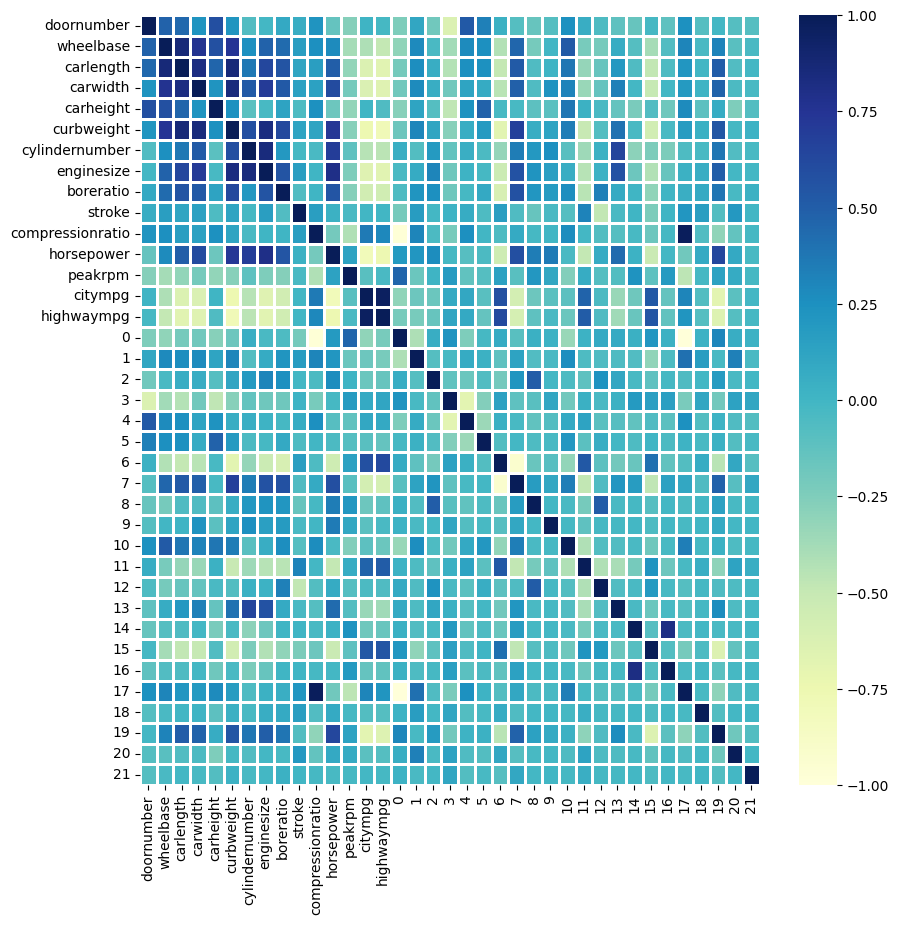

In [103]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(),cmap='YlGnBu',linewidth=2)

In [104]:
#check each column in heatmap table with correlation higher than 0.5
dict_corr=dict()
for col in X_train.corr().columns:
    val_corr=[corr for corr in X_train.corr()[col] if corr > 0.6 or corr < -0.6]
    dict_corr[col]=len(val_corr)
print(dict_corr)    

{'doornumber': 2, 'wheelbase': 4, 'carlength': 7, 'carwidth': 8, 'carheight': 1, 'curbweight': 11, 'cylindernumber': 4, 'enginesize': 8, 'boreratio': 3, 'stroke': 1, 'compressionratio': 3, 'horsepower': 8, 'peakrpm': 1, 'citympg': 8, 'highwaympg': 9, 0: 3, 1: 1, 2: 1, 3: 3, 4: 2, 5: 1, 6: 5, 7: 3, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 1, 19: 5, 20: 1, 21: 1}


**deleting feature that have high correlation with other feature based on heatmap tabel**

**deleting curbweight**

In [105]:
del_columns=['curbweight']
X_train_fs=X_train_fs.drop(columns=del_columns)
X_test_fs=X_test_fs.drop(columns=del_columns)

In [106]:
#check each column in heatmap table with correlation higher than 0.5
dict_corr=dict()
for col in X_train_fs.corr().columns:
    val_corr=[corr for corr in X_train_fs.corr()[col] if corr > 0.6 or corr < -0.6]
    dict_corr[col]=len(val_corr)
print(dict_corr)    

{'doornumber': 2, 'wheelbase': 3, 'carlength': 6, 'carwidth': 7, 'carheight': 1, 'cylindernumber': 4, 'enginesize': 7, 'boreratio': 2, 'stroke': 1, 'compressionratio': 3, 'horsepower': 7, 'peakrpm': 1, 'citympg': 7, 'highwaympg': 8, 0: 3, 1: 1, 2: 1, 3: 3, 4: 2, 5: 1, 6: 4, 7: 2, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 1, 19: 5, 20: 1, 21: 1}


In [107]:
X_train_fs=scaler.fit_transform(X_train_fs)
X_test_fs=scaler.transform(X_test_fs)

In [108]:
model_fs=LinearRegression()
model_fs.fit(X_train_fs,y_train)
predict_fs=model_fs.predict(X_test_fs)
fs_evaluation=evaluation_regression(predict_fs,y_test)

mse:13940238.845064055
rmse:3733.662926010335
r_squared:0.8323361050308137
mae:2408.2120123526925


## COMBINE METHOD

In [109]:
X_train_com=X_train.copy()
X_test_com=X_test.copy()

In [110]:
#feature binning

#wheelbase binning
X_train_com['wheelbase']=pd.qcut(X_train_com['wheelbase'],q=3,labels=[1,2,3])
X_test_com['wheelbase']=pd.qcut(X_test_com['wheelbase'],q=3,labels=[1,2,3])

#stroke binning
X_train_com['stroke']=pd.qcut(X_train_com['stroke'],q=3,labels=[1,2,3])
X_test_com['stroke']=pd.qcut(X_test_com['stroke'],q=3,labels=[1,2,3])

#horsepower binning
X_train_com['horsepower']= pd.qcut(X_train_com['horsepower'],q=4,labels=[1,2,3,4])
X_test_com['horsepower'] = pd.qcut(X_test_com['horsepower'],q=4,labels=[1,2,3,4])

#citympg binning
X_train_com['citympg']=X_train_com['citympg']//10
X_test_com['citympg']=X_test_com['citympg']//10



In [111]:
scaler=MinMaxScaler()

In [112]:
X_train_com=scaler.fit_transform(X_train_com)
X_test_com=scaler.transform(X_test_com)



In [114]:
com_model=PLSRegression(n_components=11)
com_model.fit(X_train_com,y_train)
predict_com=com_model.predict(X_test_com)
com_evaluation=evaluation_regression(predict_com,y_test)

mse:11955406.966187615
rmse:3457.659174381942
r_squared:0.8270972199767914
mae:2218.34469460031


## MODEL EVALUATION

In [118]:
model_list=['baseline model','binning model','feature selection model',
            'combine method','PLSRegression Method','XGBRegressor']
baseline_model=baseline_evaluation
binning_model=bin_evaluation
fs_model=fs_evaluation
com_model=com_evaluation
pls_model=pls_evaluation
xgbr_model=xgb_bin_evaluation
xgbr_optuna=xgbr_optuna_eval
data=[baseline_model,binning_model,fs_model,com_model,pls_model,xgbr_model,xgbr_optuna]
res_df=pd.DataFrame(data,index=['Baseline Method','Binning Model','Feature Selection Method',
                                'Combine Method','PLSRegression Method','XGBRegressor','XGBRegressor Optuna'],
                   columns=['mse','rmse','mae','r2_score'])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
res_df=res_df.sort_values(by=['mse','rmse'],ascending=True)
res_df

,mse,rmse,mae,r2_score
XGBRegressor Optuna,4612880.36,2147.76,1222.41,0.94
XGBRegressor,5642712.26,2375.44,1555.98,0.94
Binning Model,9633495.55,3103.79,2050.99,0.87
Combine Method,11955406.97,3457.66,2218.34,0.83
Baseline Method,13566715.98,3683.30,2328.06,0.83
Feature Selection Method,13940238.85,3733.66,2408.21,0.83
PLSRegression Method,14352501.65,3788.47,2345.91,0.81


In [119]:
mae_table=res_df.sort_values('mae',ascending=True)

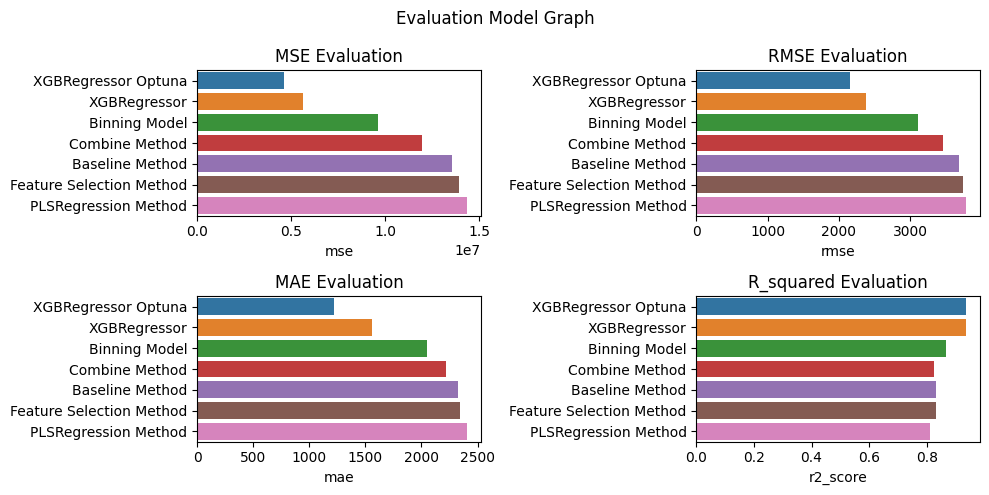

In [120]:
fig=plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
sns.barplot(data=res_df,x='mse',y=res_df.index).set_title('MSE Evaluation')

plt.subplot(2,2,2)
sns.barplot(data=res_df,x='rmse',y=res_df.index).set_title('RMSE Evaluation')

plt.subplot(2,2,3)
sns.barplot(data=mae_table,x='mae',y=res_df.index).set_title('MAE Evaluation')
plt.subplot(2,2,4)

sns.barplot(data=res_df,x='r2_score',y=res_df.index).set_title('R_squared Evaluation')
plt.suptitle('Evaluation Model Graph')

plt.tight_layout()

## SAVING BEST MODEL WHICH HAVE LEAST MSE SCORE

In [54]:
filename='car_price_predictor_best_model.sav'
pickle.dump(model_xgbr_optuna,open(filename,'wb'))

NameError: name 'model_xgbr_optuna' is not defined

In [63]:
load_model=pickle.load(open(filename,'rb'))

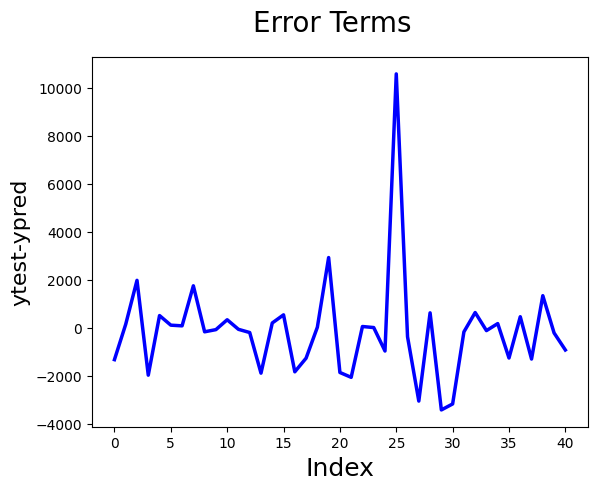

In [64]:
model_pred=load_model.predict(X_test_bin)
# Error terms
c = [i for i in range(len(model_pred))]
fig = plt.figure()
plt.plot(c,y_test-model_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label
plt.show()

In [65]:
X=X_test_bin[0]

array([1.        , 1.        , 0.76551724, 0.48571429, 0.65833333,
       0.62794838, 0.4       , 0.54296875, 0.77142857, 0.5       ,
       0.0625    , 1.        , 0.51020408, 0.        , 0.17647059,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        ])

In [ ]:
laod_model.predict()